# Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchmetrics
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

# Utilities

In [104]:
target_col = 0

class WeatherDataModule(L.LightningDataModule):
    def __init__(self, data_dir="data\current_weather_data.csv", index_='timestamp', 
                 column=0, batch_size=64, window_size=5, normalize_=False,
                 date_range = None, step_ = 24):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.index_ = index_
        self.column = column
        self.date_range = date_range
        self.window_size = window_size
        self.step_ = step_

        self.normalize_ = normalize_

    def prepare_data(self):
        df_ = pd.read_csv(self.data_dir, index_col=self.index_, parse_dates=True)
        if self.date_range != None:
            df_ = df_[self.date_range]
        
        if self.column == None:
            self.df = df_
        else:
            self.df = df_.iloc[:,self.column]
        
        if self.normalize_:
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.df.values.reshape(-1, 1))
            self.df = self.normalize(self.df)

        self.windows, self.targets = self.window_step(self.df, self.step_)
        self.windows, self.targets = self.windows.squeeze(), self.targets.squeeze()

    def window_step(self, dataset, step_ ):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-self.window_size - step_):
            feature = dataset[i:i+self.window_size]
            target = dataset[i+self.window_size:i+self.window_size+step_]
            X.append(feature)
            y.append(target)

        X_r = torch.tensor(np.array(X))
        y_r = torch.tensor(np.array(y))
        return np.array(X), np.array(y)
    
    def normalize(self, series):
        if self.column == None:
            return pd.DataFrame(self.scaler.fit_transform(series), index=series.index)
        else:
            return pd.DataFrame(self.scaler.fit_transform(series.values.reshape(-1, 1)), index=series.index)
    
    def inverse_normalze(self, series):
        if self.column == None:
            return pd.DataFrame(self.scaler.inverse_transform(series), index=series.index)
        else:
            return pd.DataFrame(self.scaler.inverse_transform(series.values.reshape(-1, 1)), index=series.index)
    
    def inverse_single_column(self, series):
        if self.column == None:
            zeros_ = pd.DataFrame(np.zeros((series.shape[0], self.df.shape[1])))
            zeros_[target_col] = series 
            return pd.DataFrame(self.scaler.inverse_transform(zeros_))[target_col]
        else:
            return pd.DataFrame(self.scaler.inverse_transform(series.reshape(-1, 1)))

    def setup(self, stage: str):
        self.split = [round(len(self.df) * 0.7), round(len(self.df) * 0.9)]

        self.f_train, self.t_train = self.windows[:self.split[0]], self.targets[:self.split[0]]
        self.f_valid, self.t_valid = self.windows[self.split[0]:self.split[1]], self.targets[self.split[0]:self.split[1]]
        self.f_test, self.t_test = self.windows[self.split[1]:], self.targets[self.split[1]:]

        print(f'Train: {self.f_train.shape}\nValid: {self.f_valid.shape}\nTest: {self.f_test.shape}')

    def train_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    # def predict_dataloader(self):
    #     return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=False)

class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, adam_ = False):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.adam_ = adam_

        self.save_hyperparameters(ignore=['model'])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = F.mse_loss(logits, true_labels)
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = F.mse_loss(logits, true_labels)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        if self.adam_:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

class PyTorchMLP_UNI(torch.nn.Module):
    def __init__(self, num_features, hidden_size = [50, 25], num_classes = 1):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # # 1st hidden layer
            # torch.nn.Flatten(),
            torch.nn.Linear(num_features, hidden_size[0]),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(hidden_size[0], hidden_size[1]),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(hidden_size[1], num_classes),
        )

    def forward(self, x):
        # x = torch.flatten(x, start_dim=1)
        # x = x.to(torch.float32)
        logits = self.all_layers(x)
        return logits


# Setup

In [224]:
train_ = False
uni = True

window_size = 24*4 
step = 24

if uni:
    column_ = 0
else:
    column_ = None

dm = WeatherDataModule(data_dir='data\Sere Wind Farm_hourly_OWM.csv', 
                       window_size=window_size, column=column_,
                       batch_size=32, step_=step, 
                       normalize_=True)

dm.prepare_data()
dm.setup('')

# Sanitity Check
if False:
    plt.plot(np.arange(window_size),dm.f_test[0], label='Input')
    plt.scatter(np.arange(window_size, window_size+step),dm.t_test[0], label='Target', s=5, c='r')
    plt.legend()
    plt.show()



Train: (6050, 96)
Valid: (1729, 96)
Test: (744, 96)


# Train

In [225]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_path = f"deep_models/keras_model_ws_{window_size}_{step}.h5"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')



def build_model(hidden_size = [64, 32], out = 1, input_shape_ = dm.f_train.shape[1]):
    model = Sequential()
    model.add(Dense(hidden_size[0], input_shape=(input_shape_,)))
    model.add(Dense(hidden_size[1], activation='relu'))
    model.add(Dense(out))

    return model

model = build_model(hidden_size=[64, 32], out=step, input_shape_=dm.f_train.shape[1])

model.compile(optimizer='adam', loss='mse')

model.fit(dm.f_train, dm.t_train, validation_data=(dm.f_valid, dm.t_valid), epochs=150, batch_size=32, verbose=1, callbacks=[early_stop, checkpoint])

#model.save(f'deep_models/keras_model_ws_{window_size}_{step}.h5')

Epoch 1/150
190/190 [==============================] - 1s 2ms/step - loss: 0.0454 - val_loss: 0.0258
Epoch 2/150
151/190 [======================>.......] - ETA: 0s - loss: 0.0254

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


190/190 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0217
Epoch 3/150
190/190 [==============================] - 0s 1ms/step - loss: 0.0239 - val_loss: 0.0221
Epoch 4/150
190/190 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0196
Epoch 5/150
190/190 [==============================] - 0s 1ms/step - loss: 0.0227 - val_loss: 0.0194
Epoch 6/150
190/190 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0190
Epoch 7/150
190/190 [==============================] - 0s 1ms/step - loss: 0.0224 - val_loss: 0.0188
Epoch 8/150
190/190 [==============================] - 0s 1ms/step - loss: 0.0221 - val_loss: 0.0192
Epoch 9/150
190/190 [==============================] - 0s 1ms/step - loss: 0.0221 - val_loss: 0.0195
Epoch 10/150
190/190 [==============================] - 0s 1ms/step - loss: 0.0219 - val_loss: 0.0188
Epoch 11/150
190/190 [==============================] - 0s 1ms/step - loss: 0.0216 - val_loss: 0.0180


In [226]:
model.evaluate(dm.f_valid, dm.t_valid)

55/55 [==============================] - 0s 914us/step - loss: 0.0179


0.017925530672073364

# Test

In [227]:
seed = 0


1/1 [==============================] - 0s 33ms/step


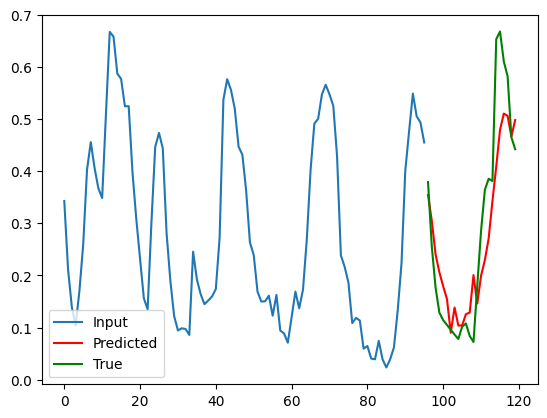

In [244]:
model_loaded = tf.keras.models.load_model(f'deep_models/keras_model_ws_{window_size}_{step}.h5')

seed += 1

prediction = model_loaded.predict(dm.f_valid[seed:seed+1]).squeeze()

plt.plot(np.arange(window_size), dm.f_valid[seed], label='Input')
plt.plot(np.arange(window_size,window_size + step), prediction, label='Predicted', c = 'r')
plt.plot(np.arange(window_size,window_size + step), dm.t_valid[seed], label='True', c = 'g')
plt.legend()
plt.show()